In [1]:
import yelpapi
import json
import requests
from  pprint import  pprint
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

#reading in county data
counties=pd.read_csv("acs2015_county_data.csv")
counties["county_string"] = counties["County"] + " County, " + counties["State"]
listofcounties = counties["county_string"].tolist()
#reading in zipcodes
zipcodes=pd.read_csv("zip_codes_states.csv")
zipcodes["county_string"] = zipcodes["county"] + " County, " + zipcodes["state"]
listofzipcodes=zipcodes["county_string"].unique().tolist()
counties.to_csv("counties.csv")
zipcodes.to_csv("zcs.csv")
fullcountylist = list(set(listofcounties) & set(listofzipcodes))
counties.head(1)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,county_string
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,"Autauga County, Alabama"


In [2]:
#creating regions
WC = ["Washington","Oregon","California","Nevada","Idaho"]
MW = ["Montana","Wyoming","North Dakota","South Dakota","Nebraska","Kansas","Minnesota","Iowa","Missouri",
      "Wisconsin","Illinois","Michigan","Indiana","Ohio","Kentucky"]
SW = ["Arizona","Utah","Colorado","New Mexico","Oklahoma","Texas"]
SE = ["Arkansas","Louisiana","Mississippi","Alabama","Tennessee","Virginia","West Virginia","North Carolina","South Carolina","Georgia","Florida"]
NE = ["District of Columbia","Pennsylvania","Maryland","Delaware","New Jersey","New York","Maine","New Hampshire","Vermont","Massachusetts","Rhode Island","Connecticut"]
counties["Region"]= np.where(counties["State"].isin(WC),'WC',
                    np.where(counties["State"].isin(MW),'MW',
                    np.where(counties["State"].isin(SW),'SW',
                    np.where(counties["State"].isin(SE),'SE',
                    np.where(counties["State"].isin(NE),'NE', 
                             'other')))))

In [3]:
#counties.groupby(["Region"]).sum()["TotalPop"]
cdf = pd.DataFrame(counties,columns=["county_string","Region"])
WClist = (cdf.groupby("Region").get_group("WC")["county_string"]).tolist()
MWlist = (cdf.groupby("Region").get_group("MW")["county_string"]).tolist()
SWlist = (cdf.groupby("Region").get_group("SW")["county_string"]).tolist()
SElist = (cdf.groupby("Region").get_group("SE")["county_string"]).tolist()
NElist = (cdf.groupby("Region").get_group("NE")["county_string"]).tolist()

sample_list = []
sample_list.extend(random.sample(list(set(WClist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(MWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SElist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(NElist) & set(fullcountylist)),2))
sample_list

['Cassia County, Idaho',
 'Cowlitz County, Washington',
 'Peoria County, Illinois',
 'Bayfield County, Wisconsin',
 'Santa Cruz County, Arizona',
 'Iron County, Utah',
 'Franklin County, Alabama',
 'Talbot County, Georgia',
 'Union County, New Jersey',
 'Lycoming County, Pennsylvania']

In [4]:
cdf.head()

,county_string,Region
0,"Autauga County, Alabama",SE
1,"Baldwin County, Alabama",SE
2,"Barbour County, Alabama",SE
3,"Bibb County, Alabama",SE
4,"Blount County, Alabama",SE


In [5]:
pldf = pd.DataFrame(columns=["region","county_string","rating","review_count","category","price"])
pldf

,region,county_string,rating,review_count,category,price


In [6]:
res_df = pd.DataFrame(columns=["name","zipcode","county_string","rating","review_count","category","price"])
res_df

,name,zipcode,county_string,rating,review_count,category,price


In [7]:
r = 0
for c in sample_list:
    county_string = str(c)
    for term in ["Italian","Mexican","Chinese","American","Indian"]:
        #we are allowed 5000 queries per 24 hours. if we run out, we can create another. till then, use this
        yelpkey="IXRN_1GI8f8J9Kj5O5GciqeyFSWR5RMh41_rADGy1KrtQ5ZABGGZEkWwot5mOka0NlzlNxXPmzYXLWk88oOV0N_YxD1MSW4kQRfJnFrwfHLtKrr2HcsjLo6uWBzAWnYx"
        try:
            offset=0
            for loopcount in range(5):
                
                response = requests.get(url="https://api.yelp.com/v3/businesses/search", 
                       params= {"location": county_string,"term": term, "limit":"50", "offset": offset}, 
                       headers={'Authorization': 'bearer %s' % yelpkey})
                responsejson = response.json()
                offset += 50
                try:
                    count=0
            
                    for x in range(0,49):
                        for y in range(0,len(responsejson["businesses"][x]["categories"])):
                            
                            if ((str(responsejson["businesses"][x]["categories"][y]["title"]).startswith(str(term))) and 
                                (responsejson["businesses"][x]["review_count"] > 0)):
                        
                                zc = int(responsejson["businesses"][x]["location"]["zip_code"])
                                if (zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0]== county_string):
                            
#                                     print("\n",responsejson["businesses"][x]["name"],
#                                           responsejson["businesses"][x]["location"]["zip_code"],
#                                           zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0],
#                                           responsejson["businesses"][x]["rating"],
#                                           responsejson["businesses"][x]["review_count"],
#                                           responsejson["businesses"][x]["categories"][y]["title"])
                            
                                    res_df.loc[r]=[responsejson["businesses"][x]["name"],
                                          str(zc),
                                          county_string,
                                          responsejson["businesses"][x]["rating"],
                                          responsejson["businesses"][x]["review_count"],
                                          term,
                                          responsejson["businesses"][x]["price"]]
                                          #responsejson["businesses"][x]["price"]]
                                    count += 1
                                    r += 1
                except:
                    break
    
                print("End of list. Found", count, term, "restaurants in", county_string)
        except:
            break


End of list. Found 2 Italian restaurants in Cowlitz County, Washington
End of list. Found 1 Italian restaurants in Cowlitz County, Washington
End of list. Found 0 Italian restaurants in Cowlitz County, Washington
End of list. Found 0 Italian restaurants in Cowlitz County, Washington
End of list. Found 14 Chinese restaurants in Cowlitz County, Washington
End of list. Found 0 Chinese restaurants in Cowlitz County, Washington
End of list. Found 18 American restaurants in Cowlitz County, Washington
End of list. Found 16 American restaurants in Santa Cruz County, Arizona
End of list. Found 0 Italian restaurants in Talbot County, Georgia
End of list. Found 0 Mexican restaurants in Talbot County, Georgia
End of list. Found 0 Mexican restaurants in Talbot County, Georgia
End of list. Found 0 Mexican restaurants in Talbot County, Georgia
End of list. Found 0 Chinese restaurants in Talbot County, Georgia
End of list. Found 32 Italian restaurants in Union County, New Jersey
End of list. Found 16 

In [8]:

res_df.to_csv("output1804042050.csv")
res_df.price.replace(["$","$$","$$$","$$$$"],[1,2,3,4],inplace=True)
res_df.head()



,name,zipcode,county_string,rating,review_count,category,price
0,Pizza Hut,83318,"Cassia County, Idaho",2.5,3,Italian,1
1,Aguila Con El Taco,83318,"Cassia County, Idaho",4.0,72,Mexican,1
2,Taco Bandido,83318,"Cassia County, Idaho",4.0,27,Mexican,1
3,Duck Ugly's,83318,"Cassia County, Idaho",4.0,24,American,1
4,Almo Creek Outpost,83312,"Cassia County, Idaho",5.0,5,American,2


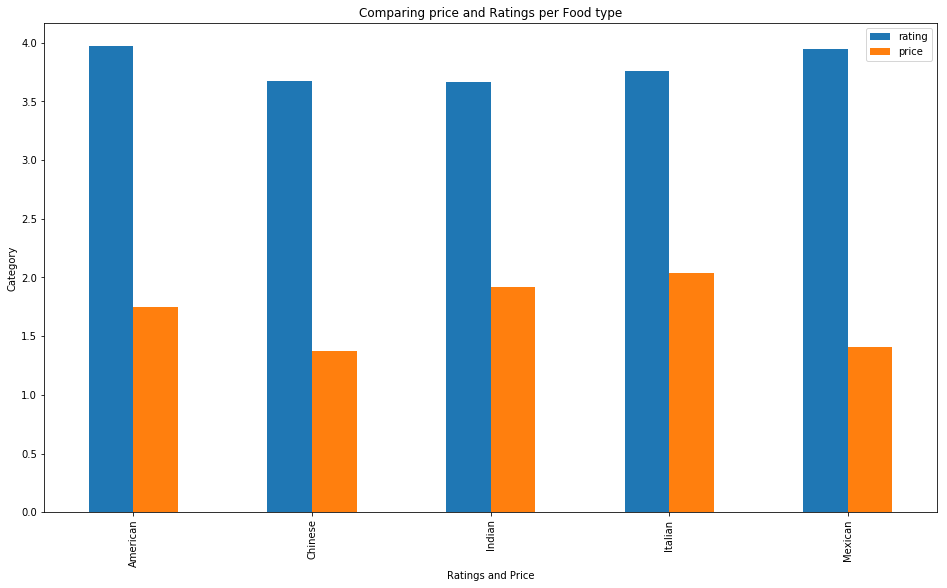

In [9]:
#MONICA










res_df.groupby("category").mean().plot(kind='bar', figsize=(16,9))
plt.xlabel("Ratings and Price")
plt.ylabel('Category')
plt.title('Comparing price and Ratings per Food type')


plt.show()
plt.savefig("Comparing_price_and_ratingcount.png")


In [10]:
Newres=pd.DataFrame(res_df["Region","Ratings","Review_Count"])
Newres.head()

KeyError: ('Region', 'Ratings', 'Review_Count')

In [11]:
res_df.groupby("Region").mean().plot(kind='bar')


plt.show()


KeyError: 'Region'

In [12]:

Ratings, = plt.plot(rating, average_unemployment, color="red", label="World Average" )

NameError: name 'rating' is not defined

In [13]:
#MONICA





























res_df = pd.merge(res_df,counties, how='left', on="county_string",)
#list(res_df)
res_df.head()


,name,zipcode,county_string,rating,review_count,category,price,CensusId,State,County,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,Pizza Hut,83318,"Cassia County, Idaho",2.5,3,Italian,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
1,Aguila Con El Taco,83318,"Cassia County, Idaho",4.0,72,Mexican,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
2,Taco Bandido,83318,"Cassia County, Idaho",4.0,27,Mexican,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
3,Duck Ugly's,83318,"Cassia County, Idaho",4.0,24,American,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
4,Almo Creek Outpost,83312,"Cassia County, Idaho",5.0,5,American,2,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC


In [15]:
res_agg = res_df.groupby(["category"])
res_agg.head()
#plt.scatter(res_df, y = "review_count", x = "category")

,name,zipcode,county_string,rating,review_count,category,price,CensusId,State,County,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,Pizza Hut,83318,"Cassia County, Idaho",2.5,3,Italian,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
1,Aguila Con El Taco,83318,"Cassia County, Idaho",4.0,72,Mexican,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
2,Taco Bandido,83318,"Cassia County, Idaho",4.0,27,Mexican,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
3,Duck Ugly's,83318,"Cassia County, Idaho",4.0,24,American,1,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
4,Almo Creek Outpost,83312,"Cassia County, Idaho",5.0,5,American,2,16031,Idaho,Cassia,...,0.7,4.2,15.4,9771,79.8,12.4,7.7,0.1,5.7,WC
5,Backstage Cafe,98626,"Cowlitz County, Washington",3.5,29,Italian,2,53015,Washington,Cowlitz,...,1.7,4.8,24.1,40418,79.0,14.8,5.8,0.4,10.7,WC
6,Lexi's Pizza Pub,98626,"Cowlitz County, Washington",4.0,58,Italian,2,53015,Washington,Cowlitz,...,1.7,4.8,24.1,40418,79.0,14.8,5.8,0.4,10.7,WC
7,Pizza Hut,98632,"Cowlitz County, Washington",1.5,15,Italian,2,53015,Washington,Cowlitz,...,1.7,4.8,24.1,40418,79.0,14.8,5.8,0.4,10.7,WC
8,El Potrillo,98626,"Cowlitz County, Washington",4.5,59,Mexican,2,53015,Washington,Cowlitz,...,1.7,4.8,24.1,40418,79.0,14.8,5.8,0.4,10.7,WC
9,La Familia Taqueria,98626,"Cowlitz County, Washington",5.0,17,Mexican,1,53015,Washington,Cowlitz,...,1.7,4.8,24.1,40418,79.0,14.8,5.8,0.4,10.7,WC


In [17]:
import seaborn as sns

print()

# create a scatter plot amplifying the marker to show better
plt.scatter(x = res_df["review_count"], y = res_df["Income_x"] , s= review_count*5 , c='#F08080', alpha=.7, edgecolor="black", marker="o", label="Urban")

plt.title("rating vs reviews")
# plt.xlabel("review_count")
plt.ylabel(" rating")
plt.text(10, 45,"Size of Bubble denotes ", fontsize=10)
plt.text(10, 43," # drivers per city", fontsize=10)
plt.legend()
sns.set
plt.show()

KeyError: 'Income_x'

In [ ]:
#MONICA












In [ ]:

# creating 3 data frames for plottting purpose
wcdf = merged[merged["Region"]=="WC"]
mwdf = merged[merged["Region"]=="MW"]
swdf = merged[merged["Region"]=="SW"]
sedf = merged[merged["Region"]=="SE"]
nedf = merged[merged["Region"]=="NE"]
#average fare per city
wcdfgrp = wcdf.groupby(['Region']).mean()['rating']
mwdfgrp = mwdf.groupby(['Region']).mean()['rating']
swdfgrp = swdf.groupby(['Region']).mean()['rating']
sedfgrp = sedf.groupby(['Region']).mean()['rating']
nedfgrp = nedf.groupby(['Region']).mean()['rating']
print(swdfgrp)


In [ ]:
# create a scatter plot amplifying the marker to show better
plt.scatter(wcdf, wcdfgrp  , s= review_count*5 , c='#F08080', alpha=.7, edgecolor="black", marker="o", label="Urban")
# plt.scatter(mwdf, SUbrbanAvfare , s= totdriversS*5 , c='#87CEFA', alpha=.7, edgecolor="black", marker="o", label="Suburban")
# plt.scatter(totridesR, RurrbanAvfare , s= totdriversR*5 , c='#FFD700', alpha=.7, edgecolor="black", marker="o", label="Rural")
# plt.title("Pyber Ride sharing Data")
# plt.xlabel("Total number of rides (per city)")
# plt.ylabel("Average Fare($)")
# plt.text(10, 45,"Size of Bubble denotes ", fontsize=10)
# plt.text(10, 43," # drivers per city", fontsize=10)
plt.legend()
sns.set
plt.show()

In [ ]:
#itadf = res_df.groupby(res_df["category"]).get_group("Italian")
mexdf = res_df.groupby(res_df["category"]).get_group("Mexican")
chndf = res_df.groupby(res_df["category"]).get_group("Chinese")
usadf = res_df.groupby(res_df["category"]).get_group("American")
inddf = res_df.groupby(res_df["category"]).get_group("Indian")
res_df
# CHA = res_df.groupby(res_df["county_string"]).get_group("Mecklenburg County, North Carolina")
# CHAbreakdown = pd.DataFrame(CHA["category"].value_counts()).T.reset_index()
# CHAbreakdown["county_string"]="Mecklenburg County, North Carolina"
# CHA_price_avg = CHA.groupby(res_df["price"]).mean()
# CHA_price_count = CHA["price"].value_counts()

# RAL = res_df.groupby(res_df["county_string"]).get_group("Wake County, North Carolina")
# RALbreakdown = pd.DataFrame(RAL["category"].value_counts()).T.reset_index()
# RALbreakdown["county_string"]="Wake County, North Carolina"
# RAL_price_avg = RAL.groupby(res_df["price"]).mean()
# RAL_price_count = RAL["price"].value_counts()

# ATL = res_df.groupby(res_df["county_string"]).get_group("Fulton County, Georgia")
# ATLbreakdown = pd.DataFrame(ATL["category"].value_counts()).T.reset_index()
# ATLbreakdown["county_string"]="Fulton County, Georgia"
# ATL_price_avg = ATL.groupby(res_df["price"]).mean()
# ATL_price_count = ATL["price"].value_counts()

# MEM = res_df.groupby(res_df["county_string"]).get_group("Shelby County, Tennessee")
# MEMbreakdown = pd.DataFrame(MEM["category"].value_counts()).T.reset_index()
# MEMbreakdown["county_string"]="Shelby County, Tennessee"
# MEM_price_avg = MEM.groupby(res_df["price"]).mean()
# MEM_price_count = MEM["price"].value_counts()


# ORL = res_df.groupby(res_df["county_string"]).get_group("Orange County, Florida")
# ORLbreakdown = pd.DataFrame(ORL["category"].value_counts()).T.reset_index()
# ORLbreakdown["county_string"]="Orange County, Florida"
# ORL_price_avg = ORL.groupby(res_df["price"]).mean()
# ORL_price_count = ORL["price"].value_counts()

# MIL = res_df.groupby(res_df["county_string"]).get_group("Milwaukee County, Wisconsin")
# MILbreakdown = pd.DataFrame(MIL["category"].value_counts()).T.reset_index()
# MILbreakdown["county_string"]="Milwaukee County, Wisconsin"
# MIL_price_avg = MIL.groupby(res_df["price"]).mean()
# MIL_price_count = MIL["price"].value_counts()

# SFC = res_df.groupby(res_df["county_string"]).get_group("San Francisco County, California")
# SFCbreakdown = pd.DataFrame(SFC["category"].value_counts()).T.reset_index()
# SFCbreakdown["county_string"]="San Francisco County, California"
# SFC_price_avg = SFC.groupby(res_df["price"]).mean()
# SFC_price_count = SFC["price"].value_counts()

# AUS = res_df.groupby(res_df["county_string"]).get_group("Travis County, Texas")
# AUSbreakdown = pd.DataFrame(AUS["category"].value_counts()).T.reset_index()
# AUSbreakdown["county_string"]="Travis County, Texas"
# AUS_price_avg = AUS.groupby(res_df["price"]).mean()
# AUS_price_count = AUS["price"].value_counts()

# PIT = res_df.groupby(res_df["county_string"]).get_group("Allegheny County, Pennsylvania")
# PITbreakdown = pd.DataFrame(PIT["category"].value_counts()).T.reset_index()
# PITbreakdown["county_string"]="Allegheny County, Pennsylvania"
# PIT_price_avg = PIT.groupby(res_df["price"]).mean()
# PIT_price_count = PIT["price"].value_counts()


In [ ]:
res_df.groupby("Region").mean().plot(kind='bar')


plt.show()
res_df.head()

In [ ]:
plt.scatter(res_df.col1, res_df.col2, s=res_df.col3)
# OR (with pandas 0.13 and up)
df.plot(kind='scatter', x='col1', y='col2', s=df.col3)

In [ ]:
# Plot Time Between Tweets
plt.plot(range(len(time_in_between)), time_in_between, marker="o", 
               linewidth=0.25, alpha=0.8, color="b")
plt.xlim([0, len(time_in_between)])
plt.ylabel("Hours Apart")
plt.xlabel("Tweets Ago")
plt.title("Tweet Velocity: %s" % target_user)
plt.show()

In [ ]:
TOTAL_price_avg = res_df.groupby(["price"]).mean()
rescount = res_df.groupby(["county_string"]).count()["name"].reset_index()
rescount.columns=['county_string', 'restaurant_count']
TOTAL_county_reviews = res_df.groupby(["county_string"]).review_count.sum().reset_index()
TOTAL_county_reviews.columns=["county_string","review_count"]
TOTAL_county_avg = res_df.groupby(res_df["county_string"]).mean().reset_index()


county_stats = TOTAL_county_avg.merge(TOTAL_county_reviews, on="county_string")
csdf = county_stats.merge(counties, on="county_string")
c_df = rescount.merge(csdf, on="county_string")
c_df.to_csv('c_df.csv')

In [ ]:
current_county="Pottawatomie County, Oklahoma"
WCO = res_df.groupby(res_df["county_string"]).get_group(current_county)
WCObreakdown = pd.DataFrame(WCO["category"].value_counts()).T.reset_index()
WCOrate = pd.DataFrame(WCO["rating"].value_counts()).T.reset_index()
WCObreakdown["county_string"]=current_county
WCO_price_avg = WCO.groupby(res_df["price"]).mean()
WCO_price_count = WCO["price"].value_counts()
WCOrate


In [ ]:
comp_df = pd.DataFrame(columns=["Italian","Mexican","Chinese","American", "Indian","county_string"])
comp_df = comp_df.append(CHAbreakdown)
comp_df = comp_df.append(RALbreakdown)
comp_df = comp_df.append(ATLbreakdown)
comp_df = comp_df.append(MEMbreakdown)
comp_df = comp_df.append(ORLbreakdown)
comp_df = comp_df.append(MILbreakdown)
comp_df = comp_df.append(SFCbreakdown)
comp_df = comp_df.append(AUSbreakdown)
comp_df = comp_df.append(PITbreakdown)
comp_df = comp_df.reset_index()
del comp_df["index"]
del comp_df["level_0"]
#comp_df["Totals"]=comp_df["Italian"]+comp_df["Mexican"]+comp_df["Chinese"]+comp_df["Indian"]+comp_df["American"]
comp_df

In [ ]:
fig, axes = plt.subplots(3,3,figsize= (16,9))
for i, (idx, row) in enumerate(comp_df.set_index("county_string").iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum()*.01)]
    ax.pie(row, labels=row.index)
    ax.set_title(idx)
fig.subplots_adjust(wspace=1)

In [ ]:
comp = pd.DataFrame(res_df["category"].groupby(res_df["county_string"]).value_counts())
comp
#I HAVE NO IDEA WHAT TO DO WITH THIS

In [ ]:
CHA = CHA["category"].value_counts().reset_index()
CHA["county_string"]="Mecklenburg County, North Carolina"
CHA.columns = ["category","count","county_string"]
CHA